# Solution

## Goal
Compute (approximately) how many coin flips are needed to detect a biased coin using a **one-sample z-test for a proportion**.

We'll use:
- Null: $H_0: p = 0.5$ (fair coin)
- Alternative: $H_1: p \neq 0.5$ (two-sided)
- Significance: $\alpha = 0.05$
- Target true bias to detect: $p = 0.6$

## Problem Statement
If the true probability of heads is $p=0.6$, find the minimum number of flips $n$ such that the z-test would (approximately) reject $H_0: p=0.5$ at level $\alpha=0.05$.

## Import Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Reproducibility
rng = np.random.default_rng(42)

## Derivation (one-sample z-test for a proportion)

For a one-sample z-test of a proportion, the test statistic is

$$
z = \frac{\hat p - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}
$$

For a two-sided test at level $\alpha$, we reject $H_0$ when $|z| \ge z_{1-\alpha/2}$.

To get an *approximate* required sample size, plug in what we expect under the alternative $p=p_1$ (here $p_1=0.6$), i.e. $\hat p \approx p_1$:

$$
z_{1-\alpha/2} \approx \frac{p_1 - p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}
$$

Solve for $n$:

$$
n \ge p_0(1-p_0)\left(\frac{z_{1-\alpha/2}}{p_1-p_0}\right)^2
$$

With $p_0=0.5$, $p_1=0.6$, and $\alpha=0.05$ ($z_{1-\alpha/2}\approx1.96$), we get $n\approx 96.04$, i.e. **$n=97$** after rounding up (often reported as “about 100 flips”).

## Assumptions / pitfalls

- This uses the **normal approximation** for $\hat p$. A common rule of thumb under $H_0$ is $n p_0 \ge 5$ and $n(1-p_0) \ge 5$ (which is easily satisfied here).
- The test uses the **null standard error** $\sqrt{p_0(1-p_0)/n}$ (the usual one-sample z-test for a proportion).
- The calculation above is an approximation, not a formal power calculation; the true power at a given $n$ will be less than 1.
- For exact control of type-I error (especially at smaller $n$), use an **exact binomial test** rather than a z-test.

In [5]:
p0 = 0.5
p1 = 0.6
alpha = 0.05

z_crit = stats.norm.ppf(1 - alpha / 2)
n_required = p0 * (1 - p0) * (z_crit / (p1 - p0)) ** 2

z_crit, n_required, int(np.ceil(n_required))

(np.float64(1.959963984540054), np.float64(96.03647051735318), 97)

## Optional: sample size for a target power

The earlier back-of-the-envelope $n$ makes the *expected* z-score under $p=0.6$ land right at the rejection threshold. That corresponds to only **moderate power** (roughly around 50%).

If you want a target power $1-\beta$ (e.g., 80%), a common normal-approximation rule of thumb for a two-sided test is:

$$
n \approx p_0(1-p_0)\left(\frac{z_{1-\alpha/2} + z_{1-\beta}}{p_1-p_0}\right)^2
$$

This is still approximate (and you’ll see slightly different formulas depending on whether you use $p_0$, $p_1$, or a pooled value in the standard error), but it’s a useful sanity check.

In [6]:
target_powers = [0.8, 0.9]
beta_values = [1 - pw for pw in target_powers]

z_beta = [stats.norm.ppf(1 - b) for b in beta_values]
n_power = [p0 * (1 - p0) * ((z_crit + zb) / (p1 - p0)) ** 2 for zb in z_beta]

list(zip(target_powers, n_power, [int(np.ceil(v)) for v in n_power]))

[(0.8, np.float64(196.22199335872733), 197),
 (0.9, np.float64(262.6855765360156), 263)]

## Simulation check (power vs. $n$)

The derivation above is a quick back-of-the-envelope calculation. In practice:
- Under $p=0.6$, the z-statistic is random because $\hat p$ is random.
- The z-test at $\alpha=0.05$ will not reject 100% of the time; it has *power* $<1$.

Below we estimate power by simulation and see what $n$ gives reasonably high power.

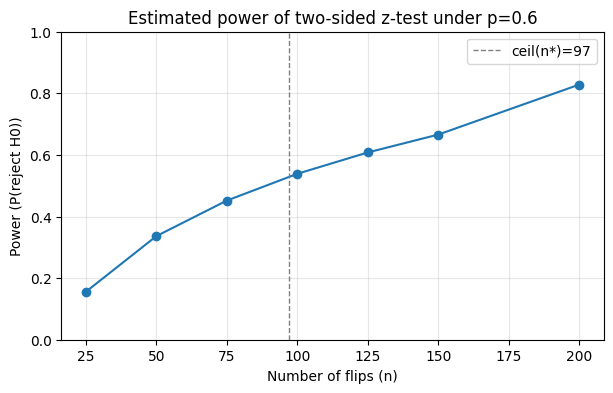

In [7]:
def ztest_reject_two_sided(
    x_heads: np.ndarray, n: int, p0: float, alpha: float
) -> np.ndarray:
    """Vectorized two-sided one-sample proportion z-test using null SE sqrt(p0(1-p0)/n)."""
    phat = x_heads / n
    se0 = np.sqrt(p0 * (1 - p0) / n)
    z = (phat - p0) / se0
    zcrit = stats.norm.ppf(1 - alpha / 2)
    return np.abs(z) >= zcrit


def estimate_power(
    n: int, p_true: float, p0: float = 0.5, alpha: float = 0.05, n_sims: int = 20_000
) -> float:
    x = rng.binomial(n=n, p=p_true, size=n_sims)
    rejects = ztest_reject_two_sided(x, n=n, p0=p0, alpha=alpha)
    return float(np.mean(rejects))


n_grid = [25, 50, 75, 100, 125, 150, 200]
powers = [
    estimate_power(n, p_true=p1, p0=p0, alpha=alpha, n_sims=10_000) for n in n_grid
]

plt.figure(figsize=(7, 4))
plt.plot(n_grid, powers, marker="o")
plt.axvline(
    int(np.ceil(n_required)),
    color="gray",
    linestyle="--",
    linewidth=1,
    label=f"ceil(n*)={int(np.ceil(n_required))}",
)
plt.title("Estimated power of two-sided z-test under p=0.6")
plt.xlabel("Number of flips (n)")
plt.ylabel("Power (P(reject H0))")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Conclusion

- Using the one-sample z-test approximation with $p_0=0.5$, $p_1=0.6$, and $\alpha=0.05$ (two-sided), the back-of-the-envelope sample size is $n\approx 96$, so $\lceil n \rceil=97$ and **“about 100 flips”** is a clean rounded answer.
- Interpreting “detect” as “the expected z-score reaches the critical value” yields only **moderate power** (the simulation around $n\approx 100$ is near 50%).
- If you want higher power (e.g., 80%+), the normal-approximation power formula suggests you may need **closer to ~200+ flips** for this effect size ($0.6$ vs $0.5$).

*(Note: For very small $n$ or when you need exact guarantees, prefer an exact binomial test and a formal power calculation.)